<a href="https://colab.research.google.com/github/2003MADHAV/Deeplearning_project_beased_experiments-/blob/main/14implementation_of_GAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, LeakyReLU, Dropout, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import SGD, Adam


In [ ]:
mnist = tf.keras.datasets.mnist
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# Scale the inputs in the range of (-1, +1) for better training
x_train, x_test = x_train / 255.0 * 2 - 1, x_test / 255.0 * 2 - 1


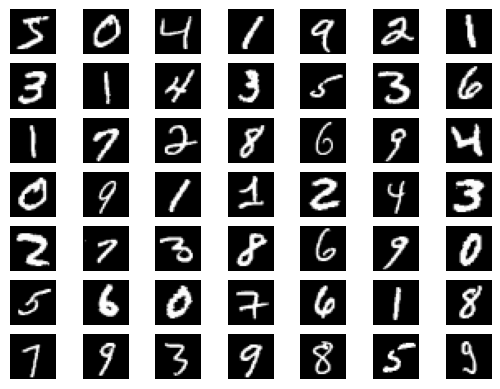

In [ ]:
import matplotlib.pyplot as plt

for i in range(49):
    plt.subplot(7, 7, i+1)
    plt.axis("off")
    plt.imshow(x_train[i], cmap='gray')  # Assuming MNIST images are grayscale
plt.show()



In [ ]:
N, H, W = x_train.shape  # number, height, width
D = H * W  # dimension (28, 28)
x_train = x_train.reshape(-1, D)
x_test = x_test.reshape(-1, D)



In [ ]:
# Defining Generator Model
latent_dim = 100

def build_generator(latent_dim):
    i = Input(shape=(latent_dim,))
    x = Dense(256, activation=LeakyReLU(alpha=0.2))(i)
    x = BatchNormalization(momentum=0.7)(x)
    x = Dense(512, activation=LeakyReLU(alpha=0.2))(x)
    x = BatchNormalization(momentum=0.7)(x)
    x = Dense(1024, activation=LeakyReLU(alpha=0.2))(x)
    x = BatchNormalization(momentum=0.7)(x)
    x = Dense(D, activation='tanh')(x)  # Because image pixels are between -1 to 1.

    model = Model(inputs=i, outputs=x)
    return model



In [ ]:
# Defining Discriminator Model
def build_discriminator(img_size):
    i = Input(shape=(img_size,))
    x = Dense(512, activation=LeakyReLU(alpha=0.2))(i)
    x = Dense(256, activation=LeakyReLU(alpha=0.2))(x)
    x = Dense(1, activation='sigmoid')(x)

    model = Model(inputs=i, outputs=x)
    return model


In [ ]:
# Compile the Discriminator
discriminator = build_discriminator(D)
discriminator.compile(
    loss='binary_crossentropy',
    optimizer=Adam(0.0002, 0.5),
    metrics=['accuracy']
)

# Build and compile the Generator
generator = build_generator(latent_dim)

# Create an input to represent noise sample from latent space
z = Input(shape=(latent_dim,))

# Pass noise through a generator to get an Image
img = generator(z)

# Make the discriminator untrainable during GAN training
discriminator.trainable = False

# Connect the Generator and Discriminator
fake_pred = discriminator(img)


In [ ]:
# Create the combined GAN model
combined_model_gen = Model(z, fake_pred)  # The first input is noise, and the second is the fake prediction.

# Compile the combined GAN model
combined_model_gen.compile(loss='binary_crossentropy', optimizer=Adam(0.0002, 0.5))


In [ ]:
batch_size = 32
epochs = 12000
sample_period = 200

ones = np.ones(batch_size)
zeros = np.zeros(batch_size)

# Store generator and discriminator loss in each step or each epoch
d_losses = []
g_losses = []

# Create a directory where the generator will save generated images
if not os.path.exists('gan_images'):
    os.makedirs('gan_images')


In [ ]:
def sample_images(epoch):
    rows, cols = 5, 5
    noise = np.random.randn(rows * cols, latent_dim)
    imgs = generator.predict(noise)

    # Rescale images to the range 0 - 1
    imgs = 0.5 * imgs + 0.5

    fig, axs = plt.subplots(rows, cols)

    # fig to plot images and axs to store subplots
    idx = 0

    for i in range(rows):
        for j in range(cols):
            axs[i, j].imshow(imgs[idx].reshape(H, W), cmap='gray')
            axs[i, j].axis('off')
            idx += 1

    fig.savefig("gan_images/%d.png" % epoch)
    plt.close()

# Main training loop
for epoch in range(epochs):
    ###########################
    ### Train discriminator ###
    ###########################

    # Select a random batch of real images
    idx = np.random.randint(0, x_train.shape[0], batch_size)
    real_imgs = x_train[idx]

    # Generate fake images
    noise = np.random.randn(batch_size, latent_dim)
    fake_imgs = generator.predict(noise)

    # Train the discriminator
    d_loss_real, d_acc_real = discriminator.train_on_batch(real_imgs, ones)
    d_loss_fake, d_acc_fake = discriminator.train_on_batch(fake_imgs, zeros)
    d_loss = 0.5 * (d_loss_real + d_loss_fake)
    d_acc = 0.5 * (d_acc_real + d_acc_fake)

    #######################
    ### Train generator ###
    #######################

    noise = np.random.randn(batch_size, latent_dim)
    g_loss = combined_model_gen.train_on_batch(noise, ones)

    # Save the losses
    d_losses.append(d_loss)
    g_losses.append(g_loss)

    if epoch % 100 == 0:
        print(f"epoch: {epoch+1}/{epochs}, d_loss: {d_loss:.2f}, d_acc: {d_acc:.2f}, g_loss: {g_loss:.2f}")

    if epoch % sample_period == 0:
        sample_images(epoch)


Streaming output truncated to the last 5000 lines.
1/1 [==============================] - 0s 20ms/step
epoch: 7101/12000, d_loss: 0.71, d_acc: 0.53, g_loss: 0.95
1/1 [==============================] - 0s 19ms/step
epoch: 7201/12000, d_loss: 0.66, d_acc: 0.62, g_loss: 1.00
1/1 [==============================] - 0s 19ms/step
epoch: 7301/12000, d_loss: 0.68, d_acc: 0.50, g_loss: 1.00
1/1 [==============================] - 0s 20ms/step
epoch: 7401/12000, d_loss: 0.65, d_acc: 0.64, g_loss: 0.99
1/1 [==============================] - 0s 19ms/step
epoch: 7501/12000, d_loss: 0.58, d_acc: 0.67, g_loss: 1.06
1/1 [==============================] - 0s 28ms/step
epoch: 7601/12000, d_loss: 0.67, d_acc: 0.56, g_loss: 1.03
1/1 [==============================] - 0s 20ms/step
epoch: 7701/12000, d_loss: 0.63, d_acc: 0.66, g_loss: 1.02
1/1 [==============================] - 0s 19ms/step
epoch: 7801/12000, d_loss: 0.66, d_acc: 0.67, g_loss: 0.98
1/1 [==============================] - 0s 21ms/step
epoch: 79

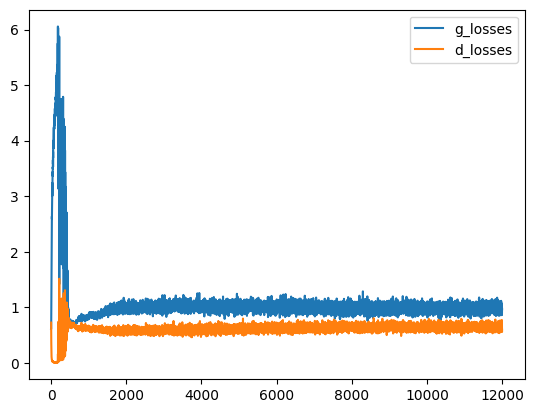

In [ ]:
plt.plot(g_losses, label='g_losses')
plt.plot(d_losses, label='d_losses')
plt.legend()

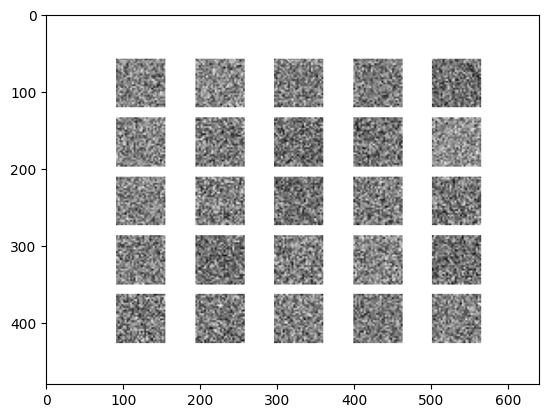

In [ ]:
#Plot the generated Image at zero epoch
from skimage.io import imread
a = imread('gan_images/0.png')
plt.imshow(a)

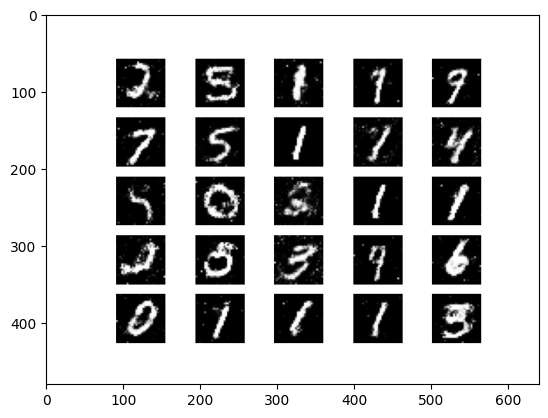

In [ ]:
from skimage.io import imread
a = imread('gan_images/10000.png')
plt.imshow(a)